In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, BatchNormalization, MaxPooling2D,Convolution3D
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using Theano backend.


In [6]:
input_data = np.array(np.load('./charge.npy'))
output_data = np.load('./truevals.npy')

In [7]:
print 'Shape of Input Data: {}'.format(np.shape(input_data))
print 'Shape of Output Data: {}'.format(np.shape(output_data))

Shape of Input Data: (100, 21, 21, 51)
Shape of Output Data: (100, 3)


In [19]:
mX = np.mean(input_data, axis=0)[np.newaxis]  # shape = (1, 32, 32, 3)
sX = np.std(input_data, axis=0)[np.newaxis]  # shape = (1, 32, 32, 3)
id_normalized = (input_data - mX)

In [21]:
print np.max(sX)

39.9975949316


In [4]:
tvt_ratio=[3,2,2] ##ratio of test validation and test dataset
data_len = len(input_data)
test_end = int(float(tvt_ratio[0])/np.sum(tvt_ratio)*data_len)
valid_end = int(float(tvt_ratio[1])/np.sum(tvt_ratio)*data_len)+test_end
print 'Range of training dataset {}:{}'.format(0,test_end)
print 'Range of validation dataset {}:{}'.format(test_end+1,valid_end)
print 'Range of test dataset {}:{}'.format(valid_end+1,data_len)

Range of training dataset 0:1730
Range of validation dataset 1731:2883
Range of test dataset 2884:4037


In [9]:
# # split train, validation and test samples
folders=['train_hist']
for folder in folders:
    if not folder in os.listdir('.'):
        os.makedirs('./{}'.format(folder))
train = input_data[0:test_end]
valid = input_data[test_end+1:valid_end]
test  = input_data[valid_end+1:data_len-1]
train_out = np.concatenate(output_data[0:test_end,0:1])
valid_out = np.concatenate(output_data[test_end+1:valid_end, 0:1])
test_out = np.concatenate(output_data[valid_end+1:data_len-1, 0:1])


In [ ]:
# # ----------------------------------------------------------
# # Define model
# # ----------------------------------------------------------


def add_block(model, nfilters, dropout=False, **kwargs):
    """ 
    Add basic convolution block: 
     - 3x3 Convolution with padding
     - Activation: ReLU
     - either MaxPooling to reduce resolution, or Dropout
     - BatchNormalization
    """
    model.add(Convolution3D(nfilters, 5, 5,5, **kwargs)) #border_mode='same', init="he_normal", 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    if dropout:
        model.add(Dropout(dropout))
    else:
        model.add(MaxPooling2D((2, 2), border_mode='same'))

def base_model():
    # # convolution part
    model = Sequential()
    model.add(Convolution3D(10, (3,3,3) , input_shape=(21, 21,51,1))) #border_mode='same', init="he_normal", 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    ##possible things to implement
    
    #model.add(Dropout(dropout))
    #model.add(MaxPooling2D((2, 2), border_mode='same'))
    
    model.add(Flatten()) 
    model.add(Dense(64))
    model.add(Activation('relu'))
    
    model.add(Dense(1, kernel_initializer='normal'))
    print(model.summary())
    
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model


# # ----------------------------------------------------------
# # Training
# # ----------------------------------------------------------

estimator = KerasRegressor(build_fn=base_model, nb_epoch=20, batch_size=5, verbose=1)
seed = 7
np.random.seed(seed)

estimator.fit(np.expand_dims(train, axis=4),train_out, 
              validation_data=(np.expand_dims(valid, axis=4), valid_out),
              callbacks=[keras.callbacks.CSVLogger('./train_hist/history.csv')],
              verbose=1)
#estimator.save('./train_hist/model.h5')  # save trained network

# print('Model performance (loss, accuracy)')
# print('Train: %.4f, %.4f' % tuple(model.evaluate(train, verbose=0, batch_size=128)))
# print('Valid: %.4f, %.4f' % tuple(model.evaluate(valid, verbose=0, batch_size=128)))
# print('Test:  %.4f, %.4f' % tuple(model.evaluate(test,  verbose=0, batch_size=128)))

INFO (theano.gof.compilelock): Refreshing lock /home/tglauch/.theano/compiledir_Linux-2.6-el6.x86_64-x86_64-with-redhat-6.4-Santiago-x86_64-2.7.10-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/tglauch/.theano/compiledir_Linux-2.6-el6.x86_64-x86_64-with-redhat-6.4-Santiago-x86_64-2.7.10-64/lock_dir/lock


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 19, 19, 49, 10)    280       
_________________________________________________________________
batch_normalization_16 (Batc (None, 19, 19, 49, 10)    40        
_________________________________________________________________
activation_19 (Activation)   (None, 19, 19, 49, 10)    0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 176890)            0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                11321024  
_________________________________________________________________
activation_20 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total para

In [26]:
estimator = load_model('./train_hist/model.h5')

KeyboardInterrupt: 

In [ ]:
res = estimator.predict(np.expand_dims(test, axis=4))

## line below throws an error
estimator.score(np.expand_dims(test, axis=4),test_out)

In [19]:
print np.shape(test_out)

(1152,)


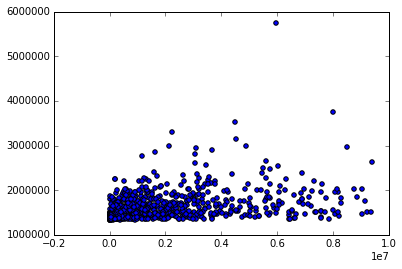

In [22]:
H, xedges, yedges= np.histogram2d(test_out, res)
plt.show()

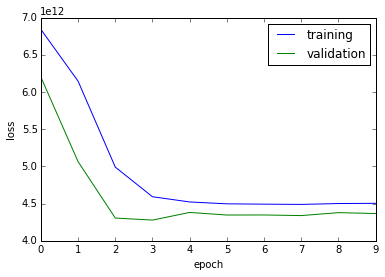

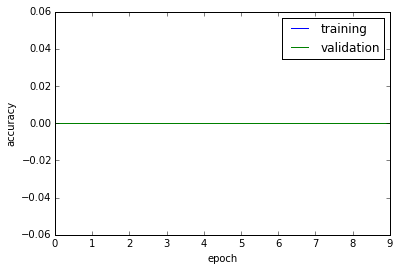

In [44]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# training curves
history = np.genfromtxt('./train_hist/history.csv', delimiter=',', names=True)

fig, ax = plt.subplots(1)
ax.plot(history['epoch'], history['loss'],     label='training')
ax.plot(history['epoch'], history['val_loss'], label='validation')
ax.legend()
ax.set(xlabel='epoch', ylabel='loss')
#fig.savefig(folder+'/loss.png')

fig, ax = plt.subplots(1)
ax.plot(history['epoch'], history['acc'],     label='training')
ax.plot(history['epoch'], history['val_acc'], label='validation')
ax.legend()
ax.set(xlabel='epoch', ylabel='accuracy')
#fig.savefig(folder+'/accuracy.png')